In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Baseline_MUSS_corrupt/muss
!pip install -e . 
!pip install -U spacy ==2.0.0
!python -m spacy download en_core_web_md

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

!pip install matplotlib==3.4
import matplotlib.pyplot as plt

from muss.mining.training import get_bart_kwargs, get_score_rows
from muss.resources.prepare import prepare_wikilarge_detokenized, prepare_asset
from muss.resources.datasets import create_smaller_dataset

from muss.fairseq.main import fairseq_train_and_evaluate_with_parametrization
from muss.mining.training import get_score_rows #get_bart_kwargs

#########################
import re
import shutil
import os 

from cachier import cachier
from easse.cli import evaluate_system_output
from easse.utils.constants import TEST_SETS_PATHS
import torch
from tqdm import tqdm

from muss.resources.paths import get_data_filepath, MODELS_DIR, get_dataset_dir
from muss.utils.helpers import add_dicts, args_str_to_dict
from muss.utils.resources import download_and_extract
from muss.preprocessors import GPT2BPEPreprocessor
from muss.preprocessing import apply_line_function_to_file
from muss.fairseq.main import get_language_from_dataset
from muss.text import truncate

from muss.simplify import simplify_sentences
from muss.utils.helpers import *

from muss.simplifiers import get_fairseq_simplifier, get_preprocessed_simplifier
from muss.preprocessors import get_preprocessors, get_preprocessor_by_name


# This dataset should exist in resources/datasets/ and contain the following files:
# train.complex, train.simple, valid.complex, valid.simple, test.complex, test.simple

# This dataset should exist in resources/datasets/ and contain the following files:
# train.complex, train.simple, valid.complex, valid.simple, test.complex, test.simple
def get_evaluate_kwargs(language, phase='valid'):
    return {
        ('en', 'valid'): {'test_set': 'asset_valid'},
        ('en', 'test'): {'test_set': 'asset_test'},
        ('fr', 'valid'): {
            'test_set': 'custom',
            'orig_sents_path': get_data_filepath('alector', 'valid', 'complex'),
            'refs_sents_paths': [get_data_filepath('alector', 'valid', 'simple')],
        },
        ('fr', 'test'): {
            'test_set': 'custom',
            'orig_sents_path': get_data_filepath('alector', 'test', 'complex'),
            'refs_sents_paths': [get_data_filepath('alector', 'test', 'simple')],
        },
        ('es', 'valid'): {
            'test_set': 'custom',
            'orig_sents_path': get_data_filepath('simplext_corpus', 'valid', 'complex'),
            'refs_sents_paths': [get_data_filepath('simplext_corpus', 'valid', 'simple')],
        },
        ('es', 'test'): {
            'test_set': 'custom',
            'orig_sents_path': get_data_filepath('simplext_corpus', 'test', 'complex'),
            'refs_sents_paths': [get_data_filepath('simplext_corpus', 'test', 'simple')],
        },
    }[(language, phase)]

evaluate_kwargs=get_evaluate_kwargs('en')


def get_predict_files(language):
    return {
        'en': [get_data_filepath('asset', 'valid', 'complex'), get_data_filepath('asset', 'test', 'complex')],
        'fr': [get_data_filepath('alector', 'valid', 'complex'), get_data_filepath('alector', 'test', 'complex')],
        'es': [
            get_data_filepath('simplext_corpus', 'valid', 'complex'),
            get_data_filepath('simplext_corpus', 'test', 'complex'),
        ],
    }[language]

def get_access_preprocessors_kwargs(language, use_short_name=False):
    return {
        'LengthRatioPreprocessor': {'target_ratio': 0.8, 'use_short_name': use_short_name},
        'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8, 'use_short_name': use_short_name},
        'WordRankRatioPreprocessor': {'target_ratio': 0.8, 'language': language, 'use_short_name': use_short_name},
        'DependencyTreeDepthRatioPreprocessor': {
            'target_ratio': 0.8,
            'language': language,
            'use_short_name': use_short_name,
        },
    }

def get_bart_kwargs(dataset, language, use_access, use_short_name=False, bart_model='bart.large'):
    assert language == 'en'

    bart_path = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/models/muss_en_wikilarge_mined/model.pt'   ### Change here
    # bart_path = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/models/bart_mined/model.pt'
# 
    arch = {
        'bart.base': 'bart_base',
        'bart.large': 'bart_large',
        'bart.large.cnn': 'bart_large',
    }[bart_model]
    kwargs = {
        'dataset': dataset,
        'metrics_coefs': [0, 1, 0],
        'parametrization_budget': 128,
        'predict_files': get_predict_files(language), # used in fairseq_evaluate_and_save
        'preprocessors_kwargs': {
            'GPT2BPEPreprocessor': {},
        },
        'preprocess_kwargs': {'dict_path': GPT2BPEPreprocessor().dict_path},
        'train_kwargs': {
            'ngpus': 1,
            'arch': arch,
            'restore_file': bart_path,
            'max_tokens': 4096,
            'lr': 8e-05,
            'warmup_updates': 500, #500
            'truncate_source': True,
            'layernorm_embedding': True,
            'share_all_embeddings': True,
            'share_decoder_input_output_embed': True,
            'reset_optimizer': True,
            'reset_dataloader': True,
            'reset_meters': True,
            'required_batch_size_multiple': 1,
            'criterion': 'label_smoothed_cross_entropy',
            'label_smoothing': 0.1,
            'dropout': 0.1,
            'attention_dropout': 0.1,
            'weight_decay': 0.01,
            'optimizer': 'adam',
            'adam_betas': '(0.9, 0.999)',
            'adam_eps': 1e-08,
            'clip_norm': 0.1,
            'lr_scheduler': 'polynomial_decay',
            'max_update': 10000, # 20000
            'skip_invalid_size_inputs_valid_test': True,
            'find_unused_parameters': True,
        },
        'evaluate_kwargs': get_evaluate_kwargs(language),
    }
    if use_access:
        kwargs['preprocessors_kwargs'] = add_dicts(
            get_access_preprocessors_kwargs(language, use_short_name=use_short_name), kwargs['preprocessors_kwargs']
        )
    return kwargs

### Compute hardword word retention rate 
def find_occurence(NE,simple_sentence):
  NE_simp = [i.lower() for i in NE['NE_simple']]
  NE_diff = [i.lower() for i in NE['NE_difficult']]
  simple_sentence = simple_sentence.lower()
  intersect_words = []

  count_simple = 0
  count_difficult = 0
  # print(NE_diff)
  # print(NE)
  if NE_simp[0] != '' or NE_diff:
    # print(NE_simp[0] == '')
  # print(sentence,test_complex_NER_spacy[index])
    if NE_simp[0] != '':
      for text in NE_simp:
        if text.lower() in simple_sentence:
          intersect_words.append(text)
          count_simple +=1
    else:
      count_simple = None
    
    if NE_diff:
      for text in NE_diff:
        if text.lower() in simple_sentence:
          intersect_words.append(text)
          count_difficult +=1
          # print('diff words found in sen')
    else:
      count_difficult = None

    return count_simple, count_difficult
  else:
    # print('empty NE')
    return None, None
    
    
def word_retention_rate(comp_sentence,simp_sentence):
  total_simp = 0
  total_diff = 0
  counter_simp = 0
  counter_diff = 0

  for i,sentence in enumerate(simp_sentence):
    NE_temp1 = NE_extraction(comp_sentence[i])[0]

    count_simp, count_diff = find_occurence(NE_temp1,sentence)

    if count_simp != None or count_diff != None:
      if count_simp != None:
        total_simp += len(NE_temp1['NE_simple'])
        counter_simp += count_simp
      if count_diff != None:
        total_diff += len(NE_temp1['NE_difficult'])
        counter_diff += count_diff
    else:
      pass
    # print(count_simp, count_diff)
  if total_diff != 0 and total_simp!=0:
    print('-'*50)
    print('simple_NE retention rate',counter_simp/total_simp)
    print('difficult_NE retention rate',counter_diff/total_diff)
    print(total_diff)
    print('total_NE retention rate', (counter_simp+counter_diff)/(total_simp+total_diff))
    print('-'*50)
    return counter_simp/total_simp,counter_diff/total_diff, (counter_simp+counter_diff)/(total_simp+total_diff)

  else:
    if total_simp != 0:
      print('-'*50)
      print('simple_NE retention rate',counter_simp/total_simp)
      print('-'*50)
      return counter_simp/total_simp
    if total_diff != 0:
      print('-'*50)
      print('difficult_NE retention rate',counter_diff/total_diff)
      # print('total_NE retention rate', (counter_simp+counter_diff)/(total_simp+total_diff))
      print('-'*50)
      # print('No stats provided for diff_NE becuase no diff NE at all')
    



def word_retention_rate_per_sentence(comp_sentence,simp_sentence):
  total_simp_list = []
  total_diff_list = []
  total_list = []
  # counter_simp_list = []
  # counter_diff_list = []

  for i,sentence in enumerate(simp_sentence):
    total_simp = 0
    total_diff = 0
    counter_simp = 0
    counter_diff = 0

    NE_temp1 = NE_extraction(comp_sentence[i])[0]

    count_simp, count_diff = find_occurence(NE_temp1,sentence)
    if count_simp != None or count_diff != None:
      if count_simp != None:
        total_simp += len(NE_temp1['NE_simple'])
        counter_simp += count_simp
      if count_diff != None:
        total_diff += len(NE_temp1['NE_difficult'])
        counter_diff += count_diff
    else:
      pass
    # print(count_simp, count_diff)
    if total_diff != 0:
      # print('simple_NE retention rate',counter_simp/total_simp)
      # print('difficult_NE retention rate',counter_diff/total_diff)
      # print('total_NE retention rate', (counter_simp+counter_diff)/(total_simp+total_diff))
      total_diff_list.append(counter_diff/total_diff)
    if total_simp != 0:
      total_simp_list.append(counter_simp/total_simp)
    if total_simp != 0 or total_diff != 0:
      total_list.append((counter_simp+counter_diff)/(total_simp+total_diff))
      # if type(counter_diff/total_diff) == float:
      #   total_diff_list.append(counter_diff/total_diff)
      # else:
      #   print(counter_diff,total_diff)
      #   total_diff_list.append(counter_diff/total_diff)

      # return counter_simp/total_simp,counter_diff/total_diff, (counter_simp+counter_diff)/(total_simp+total_diff)
    # else:
    #   total_simp_list.append(counter_simp/total_simp)
    #   total_list.append((counter_simp+counter_diff)/(total_simp+total_diff))
  print('-'*50)
  print('Word retention rate per sentence')
  print('simple_NE retention rate',np.average(total_simp_list))
  print('difficult_NE retention rate',np.average(total_diff_list))
  # print(total_diff_list)
  print('total_NE retention rate',np.average(total_list))
  print('-'*50)


def generate_output(chosen_id_list,data_dir_list,data_list,model_dir_dict,sample=False,add_to_dir_name=None,muss_output=False,NE_output=False,CERF_output=False,NE_CERF_output=False,hypothesis_num=None,beam=None,sampling=False):

  # store created dir
  created_dir = []
  output_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/output/'
  for index in chosen_id_list:
    
    # get model unique local id
    exp_dir = model_dir_dict[index]['exp_dir']
    print('| model_name is',model_dir_dict[index]['model_name'])
    print('| exp_dir is',exp_dir)

    model_name = 'model_'+ str(index) + '_'+ exp_dir.split('/')[-2]

    os.makedirs(output_dir+model_name, exist_ok=True)
    print('| output_dir',output_dir)
    language = 'en'

    # get recommended_preprocessors_kwargs
    if 'recommended_preprocessors_kwargs' in model_dir_dict[index].keys() :
      preprocessors_kwargs = model_dir_dict[index]['recommended_preprocessors_kwargs']
      print('| use provided kwargs')
    else:
      # use muss_mined_wiki preprocessors
      preprocessors_kwargs = {
            'LengthRatioPreprocessor': {'target_ratio': 0.9, 'use_short_name': False},
            'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.65, 'use_short_name': False},
            'WordRankRatioPreprocessor': {'target_ratio': 0.75, 'language': language, 'use_short_name': False},
            'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.4, 'language': language, 'use_short_name': False},
        }
      preprocessors_kwargs['GPT2BPEPreprocessor'] = {}

    print('| use preprocessors_kwargs',preprocessors_kwargs)
    preprocessors = get_preprocessors(preprocessors_kwargs)

    if hypothesis_num == None:
      hypothesis_num = 1
    if beam == None:
      beam=5

    generate_kwargs = {'hypothesis_num':hypothesis_num,
                       'beam':beam,
                       'sampling':sampling}

    simplifier = get_fairseq_simplifier(exp_dir, **generate_kwargs)
    simplifier = get_preprocessed_simplifier(simplifier, preprocessors=preprocessors)

    #########################################
    # simplify sample sentences 

    ############################## I need to change the directory 
    if sample:
      if muss_output:
        complex_file_dir = '/content/drive/MyDrive/muss/scripts/contract_no_token.en'
      elif NE_output:
        complex_file_dir = '/content/drive/MyDrive/muss/scripts/contract_NE_token.en'
      elif CERF_output:
        complex_file_dir = '/content/drive/MyDrive/muss/scripts/contract_ABCD_token.en'
      elif NE_CERF_output:
        complex_file_dir = '/content/drive/MyDrive/muss/scripts/contract_NE_ABCD_token.en'

      pred_path = simplifier(complex_file_dir)

      for i in range(len(read_lines(complex_file_dir))):
        print('original:\n',read_lines(complex_file_dir)[i])
        print('simplified:\n',read_lines(pred_path)[i])
        print('----------------------------------------------------')

      return read_lines(complex_file_dir),read_lines(pred_path)
    ###########################################

    # create dir for output
    subfolders = os.listdir(output_dir + model_name)
    num_subfolder = len(subfolders)
    new_folder_dir = output_dir + model_name + '/' +str(num_subfolder).zfill(2) +'/'
    os.mkdir(new_folder_dir)
    created_dir.append(new_folder_dir)

     # simplify asset dataset
    for index, file_dir in enumerate(data_dir_list):
      
      info_file_name = new_folder_dir + 'info.txt'
      with open(info_file_name, 'w') as f:
        f.write("generate_kwargs %s\n" % generate_kwargs)
      f.close()

      filename = new_folder_dir + data_list[index]
      print('filename;', filename)
      pred_path = simplifier(file_dir)

      with open(filename, 'w') as f:
          for item in read_lines(pred_path):
              f.write("%s\n" % item)

  print('created_dir',created_dir)
  return created_dir

def word_retention_rate_NER(NER,simp_sentence):
  total_simp = 0
  total_diff = 0
  counter_simp = 0
  counter_diff = 0

  for i,sentence in enumerate(simp_sentence):
    NE_temp1 = {'NE_simple':NER[i],'NE_difficult':[]}

    count_simp, count_diff = find_occurence(NE_temp1,sentence)

    if count_simp != None or count_diff != None:
      if count_simp != None:
        total_simp += len(NE_temp1['NE_simple'])
        counter_simp += count_simp
      if count_diff != None:
        total_diff += len(NE_temp1['NE_difficult'])
        counter_diff += count_diff
    else:
      pass
    # print(count_simp, count_diff)
  if total_diff != 0 and total_simp!=0:
    print('-'*50)
    print('simple_NE retention rate',counter_simp/total_simp)
    print('difficult_NE retention rate',counter_diff/total_diff)
    print(total_diff)
    print('total_NE retention rate', (counter_simp+counter_diff)/(total_simp+total_diff))
    print('-'*50)
    return counter_simp/total_simp,counter_diff/total_diff, (counter_simp+counter_diff)/(total_simp+total_diff)

  else:
    if total_simp != 0:
      print('-'*50)
      print('simple_NE retention rate',counter_simp/total_simp)
      print('-'*50)
      return counter_simp/total_simp
    if total_diff != 0:
      print('-'*50)
      print('difficult_NE retention rate',counter_diff/total_diff)
      # print('total_NE retention rate', (counter_simp+counter_diff)/(total_simp+total_diff))
      print('-'*50)
      # print('No stats provided for diff_NE becuase no diff NE at all')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Baseline_MUSS_corrupt/muss
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/drive/MyDrive/Baseline_MUSS_corrupt/muss
  Cloning https://github.com/feralvam/easse.git to /tmp/pip-install-_suwlrum/easse_75701566c38745a4b021388fcce54288
  Running command git clone -q https://github.com/feralvam/easse.git /tmp/pip-install-_suwlrum/easse_75701566c38745a4b021388fcce54288
  Cloning https://github.com/kpu/kenlm.git to /tmp/pip-install-_suwlrum/kenlm_2559652ed9aa4a90809784a7fcf6b574
  Running command git clone -q https://github.com/kpu/kenlm.git /tmp/pip-install-_suwlrum/kenlm_2559652ed9aa4a90809784a7fcf6b574
  Cloning https://github.com/facebookresearch/text-simplification-evaluation.git (to revision main) to /tmp/pip-install-_suwlrum/tseval_4d85294a1ba6426fa54697f723968

In [2]:
def reconstruct_simplified_data_extra_NE(complex_sentence, simple_sentence):        ### reconstruct the sentence with only NE that doesn't appear

    control_tokens = [" <NEXT_NE> "," <NEXT_DIFFICULT_WORD> "," <SENT_START> "]
    # print('-'*10)
    temp_NE = NE_extraction(complex_sentence)[0]
    new_NE = {'NE_simple':[],'NE_difficult':[]}
    # print(temp_NE)
    for key, value in temp_NE.items():
      for word in temp_NE[key]:
        if word != '' and word != ['']:
          if word not in simple_sentence:
            new_NE[key].append(word)
        else:
          # print(word)
          pass
    # print(new_NE,'---')

#################
    # indice_of_start = list_duplicates_of(complex_sentence,control_tokens[2])
    sentence = control_tokens[0] + control_tokens[0].join(new_NE['NE_simple']) + control_tokens[2] + simple_sentence
#################
    # Change here to eliminate difficult words 
    # indice_of_start_diff = list_duplicates_of(complex_sentence,control_tokens[1])

    # sentence = control_tokens[0] + control_tokens[0].join(new_NE['NE_simple']) + control_tokens[1].join(new_NE['NE_difficult']) + control_tokens[2] + simple_sentence
#################    
    return sentence


def reconstruct_simplified_data(complex_sentence, simple_sentence):
    
    def list_duplicates_of(seq,item):
      start_at = -1
      locs = []
      while True:
          try:
              loc = seq.index(item,start_at+1)
          except ValueError:
              break
          else:
              locs.append(loc)
              start_at = loc
      return locs
    
    control_tokens = ["<NEXT_NE> ","<NEXT_DIFFICULT_WORD>","<SENT_START>"]


#################
    indice_of_start = list_duplicates_of(complex_sentence,control_tokens[2])
    sentence = complex_sentence[0:indice_of_start[0]] + control_tokens[2] + simple_sentence
#################
    # Change here to eliminate difficult words 
    # indice_of_start_diff = list_duplicates_of(complex_sentence,control_tokens[1])
    # sentence = complex_sentence[0:indice_of_start_diff[0]] + control_tokens[2] + simple_sentence
#################    
    return sentence





import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pickle 

final_clrs = []
clrs = sns.color_palette('Blues_r')#'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma'
final_clrs = clrs
final_clrs




[(0.044059976931949255, 0.3338869665513264, 0.6244521337946944),
 (0.16696655132641294, 0.48069204152249134, 0.7291503267973857),
 (0.3262898885044214, 0.6186236063052672, 0.802798923490965),
 (0.5356862745098039, 0.746082276047674, 0.8642522106881968),
 (0.7309496347558632, 0.8394771241830065, 0.9213225682429834),
 (0.8584083044982699, 0.9134486735870818, 0.9645674740484429)]

[296402, 296402, 992, 992, 359, 359]


Text(0.5, 0.98, 'Distribution of the length of sentences by number of tokens')

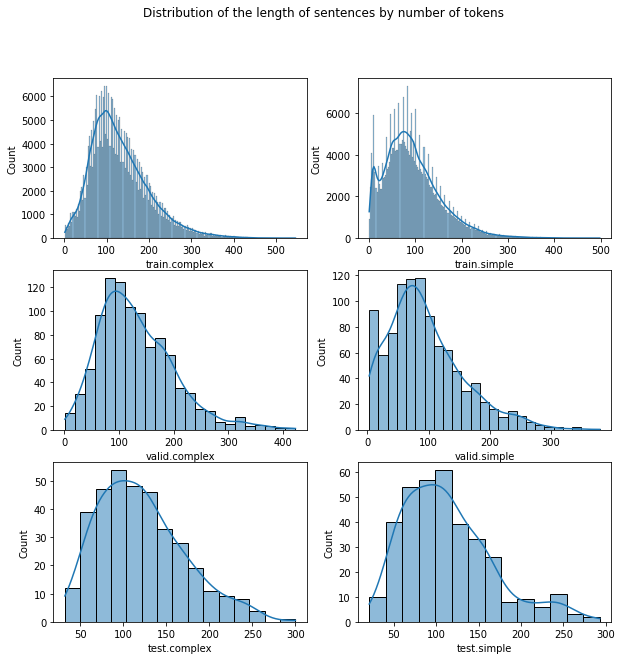

In [3]:
wiki_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/wikilarge_detokenized/'
from matplotlib.patches import Patch

wiki_train_complex = wiki_dir + 'train.complex'
wiki_valid_complex = wiki_dir + 'valid.complex'
wiki_test_complex = wiki_dir + 'test.complex'

wiki_train_simple = wiki_dir + 'train.simple'
wiki_valid_simple = wiki_dir + 'valid.simple'
wiki_test_simple = wiki_dir + 'test.simple'


wiki_data_dir = [wiki_train_complex,wiki_train_simple,wiki_valid_complex,wiki_valid_simple,wiki_test_complex,wiki_test_simple]
# print('haha')
wiki_data_name = [str(i) for i in ['train.complex','train.simple','valid.complex','valid.simple','test.complex','test.simple']]
print([len(read_lines(i)) for i in wiki_data_dir])

sen_len_list = []
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

for i,j in enumerate(wiki_data_dir):
  temp_data = read_lines(j)
  temp_df = pd.DataFrame()
  temp_len_data = [len(sen) for sen in temp_data]
  # sen_len_list.append(temp_len_data)
  temp_df[wiki_data_name[i]] = temp_len_data
  vertical_index = [0,0,1,1,2,2]
  horisontal_index = [0,1,0,1,0,1]
  sns.histplot(data=temp_df, x=wiki_data_name[i], kde=True, ax=axs[vertical_index[i], horisontal_index[i]])

fig.suptitle('Distribution of the length of sentences by number of tokens')
  # break
# len(sen_len_list)



#load ASSET

In [4]:
asset_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/asset/'
asset_ne_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/asset_ne2/'

asset_valid = asset_dir + 'valid.complex'
asset_test = asset_dir + 'test.complex'


asset_ne_valid = asset_ne_dir + 'valid.complex'
asset_ne_test = asset_ne_dir + 'test.complex'


# read_lines(asset_test)[:10]

asset_valid_NER = [NE_extraction(i)[0]['NE_simple'] for i in read_lines(asset_ne_valid)]
asset_test_NER = [NE_extraction(i)[0]['NE_simple'] for i in read_lines(asset_ne_test)]

#Load wiki test 

In [5]:
wiki_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/wikilarge_detokenized/'

wiki_valid = wiki_dir + 'valid.complex'
wiki_test = wiki_dir + 'test.complex'


wiki_test_NER = [NE_extraction(i)[0]['NE_simple'] for i in read_lines(asset_ne_test)]

#TEST baseline

In [6]:
simp_sentence_baseline_asset = simplify_sentences(read_lines(asset_test))
# simp_sentence_baseline_wiki = simplify_sentences(read_lines(wiki_test))

simp_sentence_baseline = [simp_sentence_baseline_asset]


/usr/local/lib/python3.7/dist-packages/fairseq/search.py:140: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size
/usr/local/lib/python3.7/dist-packages/fairseq/sequence_generator.py:651: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = idx // beam_size


In [7]:
df_ref = pd.DataFrame( columns =['add', 'keep', 'del'], dtype = float)

for i,data in enumerate(simp_sentence_baseline):
  word_retention_rate_NER(asset_test_NER,data)
  baseline_path = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/output/muss_wikilarge_mined/00/'

  with open(baseline_path+'asset_test_baseline','w') as f:
    for sen in data:
      f.write("{}\n".format(sen))
  baseline_test = baseline_path + 'asset_test_baseline'

  print(ast.literal_eval(os.popen("easse evaluate -t asset_test -m 'bleu,sari,fkgl' -q < %s" %baseline_test).read()))
  sari_ope_baseline = list(ast.literal_eval(os.popen("easse evaluate -t asset_test -m 'sari_by_operation' -q < %s" %baseline_test).read()).values())
  df_ref.loc[i] = sari_ope_baseline[0:3]

df_ref

--------------------------------------------------
simple_NE retention rate 0.6024785510009533
--------------------------------------------------
{'bleu': 55.998, 'sari': 43.547, 'fkgl': 5.46, 'quality_estimation': {'Compression ratio': 0.898, 'Sentence splits': 1.451, 'Levenshtein similarity': 0.7, 'Exact copies': 0.0, 'Additions proportion': 0.311, 'Deletions proportion': 0.334, 'Lexical complexity score': 7.762}}


,add,keep,del
0,11.183,54.197,65.26


In [8]:
word_retention_rate_NER(asset_test_NER,simp_sentence_baseline_asset)
example_df_baseline = pd.DataFrame(columns = ['Original Sentence','Simplified Sentence'])
for i in range(10):
  example_df_baseline.loc[i] = [read_lines(asset_test)[i],simp_sentence_baseline_asset[i]]

example_df_baseline

with pd.option_context("max_colwidth", 1000):
  latex_output = example_df_baseline.to_latex(index = False)
  latex_output = latex_output.replace("\\\n", "\\ \hline\n")
  print(latex_output)
  # print(example_df_baseline.to_latex(multirow = True))
  # example_df_baseline

--------------------------------------------------
simple_NE retention rate 0.6024785510009533
--------------------------------------------------
\begin{tabular}{ll}
\toprule
                                                                                                                                                                                                                                        Original Sentence &                                                                                                                                                                                                                       Simplified Sentence \\ \hline
\midrule
                                      One side of the armed conflicts is composed mainly of the Sudanese military and the Janjaweed, a Sudanese militia group recruited mostly from the Afro-Arab Abbala tribes of the northern Rizeigat region in Sudan. &                                         One side of the armed confli

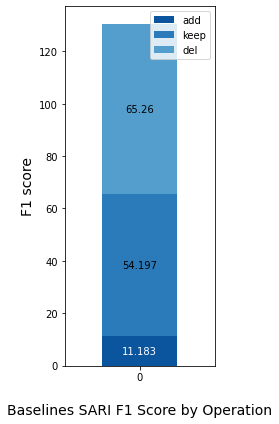

In [12]:
f, ax2= plt.subplots( figsize=(3, 6),sharey=True)

df_ref.plot(ax=ax2,kind='bar', stacked=True,  rot=0, color=final_clrs,legend=True)
for index,c in enumerate(ax2.containers):
    if index !=0:
      ax2.bar_label(c, label_type='center')
    else:
      ax2.bar_label(c, label_type='center',color='white')

ax2.set_ylabel('F1 score',fontsize=14)
# ax2.set_xlabel('# Prefixed Named Entities\nfrom Simple sentence',fontsize=14)
ax2.set_xlabel('\nBaselines SARI F1 Score by Operation',fontsize=14)

plt.tight_layout()

# plt.savefig('trend_sari_ope.pdf',bbox_inches='tight')
plt.show()

# Fine-tuned MUSS

In [10]:
MODEL_DIR = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/experiments/fairseq/'
Temp_data_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/qualitative/'
Temp_data_name = 'process_sentence1'
asset_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/asset/'
asset_ne_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/asset_ne2/'
asset_tag = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/asset_tag/'
asset_prefix_tag = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/asset_prefix_tag/'

# print(read_lines(asset_prefix_tag + 'test.complex')[:5])





model_dir_dict = {}
def add_item_to_dict(**kwargs):

  id = len(model_dir_dict)
  model_dir_dict[id]={}

  for key, value in kwargs.items():
    model_dir_dict[id][key]=value
  print('added:',model_dir_dict[id])

add_item_to_dict(model_id=len(model_dir_dict),exp_dir= MODEL_DIR+'local_1662588508499/',model_name='MUSS_prefix_token',recommended_preprocessors_kwargs={'LengthRatioPreprocessor': {'target_ratio': 0.7833992045638967, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8667233887101137, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.5945757675511544, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.489874862387003, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}})
add_item_to_dict(model_id=len(model_dir_dict),exp_dir= MODEL_DIR+'local_1662592794178/',model_name='MUSS_prefix_tag_token',recommended_preprocessors_kwargs={'LengthRatioPreprocessor': {'target_ratio': 0.7914395197909916, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8295883262010001, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.826147340880218, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.36273572141178184, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}})
add_item_to_dict(model_id=len(model_dir_dict),exp_dir= MODEL_DIR+'local_1662500425274/',model_name='MUSS_tag_token',recommended_preprocessors_kwargs={'LengthRatioPreprocessor': {'target_ratio': 0.8421908748934228, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8480454493132732, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.8832210383250984, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.3388928469969324, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}})

# print(len(model_dir_dict))
#load test dataset 
test_data_dir_list,test_data_list = [asset_ne_dir+'test.complex',asset_prefix_tag+'test.complex',asset_tag+'test.complex' ],['ne.test.complex.pred'for i in range(len(model_dir_dict))]
model_dir_dictx = model_dir_dict

model_dir_dictx

added: {'model_id': 0, 'exp_dir': '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/experiments/fairseq/local_1662588508499/', 'model_name': 'MUSS_prefix_token', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 0.7833992045638967, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8667233887101137, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.5945757675511544, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.489874862387003, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}}
added: {'model_id': 1, 'exp_dir': '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/experiments/fairseq/local_1662592794178/', 'model_name': 'MUSS_prefix_tag_token', 'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 0.7914395197909916, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.

{0: {'model_id': 0,
  'exp_dir': '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/experiments/fairseq/local_1662588508499/',
  'model_name': 'MUSS_prefix_token',
  'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 0.7833992045638967,
    'use_short_name': False},
   'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8667233887101137,
    'use_short_name': False},
   'WordRankRatioPreprocessor': {'target_ratio': 0.5945757675511544,
    'language': 'en',
    'use_short_name': False},
   'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.489874862387003,
    'language': 'en',
    'use_short_name': False},
   'GPT2BPEPreprocessor': {}}},
 1: {'model_id': 1,
  'exp_dir': '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/experiments/fairseq/local_1662592794178/',
  'model_name': 'MUSS_prefix_tag_token',
  'recommended_preprocessors_kwargs': {'LengthRatioPreprocessor': {'target_ratio': 0.7914395197909916,
    'use_short_name': False},
   'Replac

In [11]:
token_ori_1 = generate_output([i for i in range(len(model_dir_dictx))],test_data_dir_list,test_data_list, model_dir_dictx)

| model_name is MUSS_prefix_token
| exp_dir is /content/drive/MyDrive/Baseline_MUSS_corrupt/muss/experiments/fairseq/local_1662588508499/
| output_dir /content/drive/MyDrive/Baseline_MUSS_corrupt/muss/output/
| use provided kwargs
| use preprocessors_kwargs {'LengthRatioPreprocessor': {'target_ratio': 0.7833992045638967, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8667233887101137, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.5945757675511544, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.489874862387003, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}}
filename; /content/drive/MyDrive/Baseline_MUSS_corrupt/muss/output/model_0_local_1662588508499/36/ne.test.complex.pred


/usr/local/lib/python3.7/dist-packages/fairseq/search.py:140: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size
/usr/local/lib/python3.7/dist-packages/fairseq/sequence_generator.py:651: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = idx // beam_size


filename; /content/drive/MyDrive/Baseline_MUSS_corrupt/muss/output/model_0_local_1662588508499/36/ne.test.complex.pred
filename; /content/drive/MyDrive/Baseline_MUSS_corrupt/muss/output/model_0_local_1662588508499/36/ne.test.complex.pred


KeyboardInterrupt: ignored

In [ ]:
df_metrics = pd.DataFrame(columns =['BLEU', 'SARI', 'FKGL', 'NE_retention rate'], dtype = float)
df_sari_breaksdown = pd.DataFrame( columns =['add', 'keep', 'del'], dtype = float)


for i,path in enumerate(token_ori_1):
  print('-'*80)
  print(model_dir_dictx[i]['model_name'])
  comp_sentence1, simp_sentence1 = read_lines(test_data_dir_list[i]), read_lines(path+test_data_list[i])
  NE_retention_rate = word_retention_rate_NER(asset_test_NER,simp_sentence1)

  metrics_eval = ast.literal_eval(os.popen("easse evaluate -t asset_test -m 'bleu,sari,fkgl' -q < %s" % path+test_data_list[i]).read())

  metrics = list(metrics_eval.values())[0:3]

  print(metrics_eval)
  sari_breakdown = ast.literal_eval(os.popen("easse evaluate -t asset_test -m 'sari_by_operation' -q < %s" %path+test_data_list[i]).read())
  sari_ope_baseline = list(sari_breakdown.values())
  print(sari_breakdown)
  print('-'*80)
  [print(comp_sentence1[i],'\n',simp_sentence1[i]) for i in range(10)]
  metrics.append(NE_retention_rate)
  # metrics.append(NE_retention_rate)
  df_metrics.loc[model_dir_dictx[i]['model_name']] = metrics
  df_sari_breaksdown.loc[model_dir_dictx[i]['model_name']] = sari_ope_baseline[0:3]
  # df_metrics.set_index = (model_dir_dictx[i]['model_name'])
print(df_metrics)
print(df_sari_breaksdown)

In [ ]:
df_metricsT = df_metrics.T
df_sari_breaksdownT = df_sari_breaksdown.T

fig1, ax = plt.subplots(figsize=(15, 8))
df_metricsT.plot(ax=ax, kind="bar",color=final_clrs,width=0.8)
plt.xticks(rotation=0)
for bars in ax.containers:
    ax.bar_label(bars)



fig2, ax = plt.subplots(figsize=(15, 8))
df_sari_breaksdownT.plot(ax=ax, kind="bar",color=final_clrs,width=0.8)
plt.xticks(rotation=0)
for bars in ax.containers:
    ax.bar_label(bars)



## 6 NE-recovery Model

### Prefix all

In [ ]:
### Load data 

asset_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/asset/'
asset_ne_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/asset_ne2/'
asset_ne2_simp_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/asset_ne2_simp/'

# asset_valid = asset_dir + 'valid.complex'
asset_test = asset_dir + 'test.complex'


# asset_ne_valid = asset_ne_dir + 'valid.complex'
asset_ne_test = asset_ne_dir + 'test.complex'
asset_ne2_simp = asset_ne2_simp_dir + 'test.complex'

# read_lines(asset_test)[:10]

# asset_valid_NER = [NE_extraction(i)[0]['NE_simple'] for i in read_lines(asset_ne_valid)]
asset_test_NER = [NE_extraction(i)[0]['NE_simple'] for i in read_lines(asset_ne2_simp)]

# asset_test_NER

In [ ]:


MODEL_DIR = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/experiments/fairseq/'
Temp_data_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/qualitative/'
Temp_data_name = 'process_sentence1'
asset_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/asset/'
asset_ne_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/asset_ne2/'
# asset_tag = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/asset_tag/'
# asset_prefix_tag = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/asset_prefix_tag/'
asset_ne2_simp_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/asset_ne2_simp/'
model_dir_dict = {}

temp_data = read_lines(asset_ne2_simp_dir+'test.complex')
print("Current NE_Retention rate")
print(word_retention_rate(temp_data,[NE_extraction(i)[1] for i in temp_data]))
print('-'*50)


def add_item_to_dict(**kwargs):

  id = len(model_dir_dict)
  model_dir_dict[id]={}

  for key, value in kwargs.items():
    model_dir_dict[id][key]=value
  print('added:',model_dir_dict[id])

add_item_to_dict(model_id=len(model_dir_dict),exp_dir= MODEL_DIR+'local_1662418124367/',model_name='BART_Prefix_all',recommended_preprocessors_kwargs={'LengthRatioPreprocessor': {'target_ratio': 0.7324409180496487, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.960122996148627, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 1.026913449646228, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 1.486515239255297, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}})
add_item_to_dict(model_id=len(model_dir_dict),exp_dir= MODEL_DIR+'local_1662678465719/',model_name='BART_Prefix_3',recommended_preprocessors_kwargs={'LengthRatioPreprocessor': {'target_ratio': 0.5234855446646561, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.48476024808318263, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.3144393815438586, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.41094887217546694, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}})
add_item_to_dict(model_id=len(model_dir_dict),exp_dir= MODEL_DIR+'local_1663238941625/',model_name='BART_Prefix_1',recommended_preprocessors_kwargs={'LengthRatioPreprocessor': {'target_ratio': 0.9616412197210658, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.4857536034959601, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.6757444282592101, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 1.193173401274045, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}})

add_item_to_dict(model_id=len(model_dir_dict),exp_dir= MODEL_DIR+'local_1662418175945/',model_name='MUSS_Prefix_all',recommended_preprocessors_kwargs={'LengthRatioPreprocessor': {'target_ratio': 0.2215941822728957, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.5444194384423007, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.8871391583847024, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.4673570981388741, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}})
add_item_to_dict(model_id=len(model_dir_dict),exp_dir= MODEL_DIR+'local_1662674712992/',model_name='MUSS_Prefix_3',recommended_preprocessors_kwargs={'LengthRatioPreprocessor': {'target_ratio': 0.8105374088855568, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8901477513058461, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 1.0108465890264753, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.4286785191628438, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}})
add_item_to_dict(model_id=len(model_dir_dict),exp_dir= MODEL_DIR+'local_1663023308800/',model_name='MUSS_Prefix_1',recommended_preprocessors_kwargs={'LengthRatioPreprocessor': {'target_ratio': 0.48297000700371007, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.41231308883881346, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 1.066563160473487, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.9209968851568208, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}})





# print(len(model_dir_dict))
#load test dataset 
test_data_dir_list_ne,test_data_list_ne = [asset_ne2_simp_dir+'test.complex' for i in range(len(model_dir_dict))],['ne.test.complex.pred'for i in range(len(model_dir_dict))]
model_dir_dictx = model_dir_dict

# model_dir_dictx



In [ ]:
test_data_list

In [ ]:
token_ori_1 = generate_output([i for i in range(len(model_dir_dictx))],test_data_dir_list_ne,test_data_list_ne, model_dir_dictx)

In [ ]:

df_metrics = pd.DataFrame(columns =['BLEU', 'SARI', 'FKGL', 'NE_retention rate'], dtype = float)
df_sari_breaksdown = pd.DataFrame( columns =['add', 'keep', 'del'], dtype = float)
df_example_sentences_list = []

for i,path in enumerate(token_ori_1):
  print('-'*80)
  print(model_dir_dictx[i]['model_name'])
  comp_sentence_ne_recovery, simp_sentence1_ne_recovery = read_lines(test_data_dir_list_ne[i]), read_lines(path+test_data_list_ne[i])
  NE_retention_rate = word_retention_rate_NER(asset_test_NER,simp_sentence1_ne_recovery)

  metrics_eval = ast.literal_eval(os.popen("easse evaluate -t asset_test -m 'bleu,sari,fkgl' -q < %s" % path+test_data_list_ne[i]).read())

  metrics = list(metrics_eval.values())[0:3]

  print(metrics_eval)
  sari_breakdown = ast.literal_eval(os.popen("easse evaluate -t asset_test -m 'sari_by_operation' -q < %s" %path+test_data_list_ne[i]).read())
  sari_ope_baseline = list(sari_breakdown.values())
  print(sari_breakdown)
  print('-'*80)
  print()
  [print('This is sentence #', i,'\n',read_lines(asset_test)[i],'\n','-'*30,'\n',comp_sentence_ne_recovery[i],'-'*30,'\n',simp_sentence1_ne_recovery[i],'\n','-'*30) for i in range(10,20)]
  metrics.append(NE_retention_rate)
  # metrics.append(NE_retention_rate)
  df_metrics.loc[model_dir_dictx[i]['model_name']] = metrics
  df_sari_breaksdown.loc[model_dir_dictx[i]['model_name']] = sari_ope_baseline[0:3]
  # df_metrics.set_index = (model_dir_dictx[i]['model_name'])



  df_example_sentence = pd.DataFrame(columns = ['Prefixed NE','Before Recovery Sentence', 'Recovered Sentence'])
  df_example_sentence_source = pd.DataFrame(columns = ['Original Sentence'])

  selected_sentence = [11,14,17]
  for idx,sen in enumerate(selected_sentence):
    df_example_sentence.loc[idx] = [NE_extraction(comp_sentence_ne_recovery[sen])[0]['NE_simple'],NE_extraction(comp_sentence_ne_recovery[sen])[1],simp_sentence1_ne_recovery[sen]]
    df_example_sentence.reset_index(drop=True, inplace=True)

    df_example_sentence_source[idx] = [read_lines(test_data_dir_list_ne[0])[i] for i in selected_sentence]

  df_example_sentences_list.append(df_example_sentence)
  # print(df_example_sentence)

  # break
print(df_metrics)
print(df_sari_breaksdown)
print('-'*50)
with pd.option_context("max_colwidth", 1000):
  for idx,df in enumerate(df_example_sentences_list):
    temp_str = "Example output of NE\_recovery Model: " + model_dir_dictx[idx]['model_name'].replace("_","\_")
    latex_output = df.to_latex(index = False, longtable = True,caption = temp_str)
    latex_output = latex_output.replace("\\\n", "\\ \hline\n")
    latex_output = latex_output.replace("{lll}", "{p{2cm}p{6cm}p{6cm}}")
    latex_output = latex_output.replace("n{longtable}", "n{table}[H]  \\\ \\begin{longtable}")

    latex_output = latex_output.replace("\end{longtable}", "\end{longtable} \\\ \\end{table}")

    print(latex_output)


In [ ]:
df_example_sentence_source = pd.DataFrame(columns = ['ASSET Sentence'])
for idx, sen in enumerate(selected_sentence):
  df_example_sentence_source.loc[idx] = NE_extraction(read_lines(test_data_dir_list[0])[sen])[1] 
with pd.option_context("max_colwidth", 1000):
    latex_out = df_example_sentence_source.to_latex(index = False)
    latex_out = latex_out.replace("\\\n", "\\ \hline\n")
    
    print(latex_out)

# while True: pass

In [ ]:

f, (ax, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(15, 6),sharey=False)


df_metricsT = df_metrics.T
# df_sari_breaksdownT = df_sari_breaksdown.T

# fig1, ax = plt.subplots(figsize=(15, 8))
df_metricsT.iloc[0:3].plot(ax=ax, kind="bar",color=final_clrs,width=0.8)
ax.tick_params(labelrotation=0)
ax.title.set_text('Simplification Metrics of NE_recovery Models')

# for bars in ax.containers:
#     ax.bar_label(bars)
df_metricsT.iloc[3].plot(ax=ax2, kind="bar",color=final_clrs,width=0.8)
# ax2.tick_params(labelrotation=45)
# plt.setp(ha="left")
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor") 
ax2.title.set_text('NE_recovery rate')


# fig2, ax = plt.subplots(figsize=(15, 8))
# df_sari_breaksdownT.plot(ax=ax, kind="bar",color=final_clrs,width=0.8)
# plt.xticks(rotation=0)
# # for bars in ax.containers:
#     ax.bar_label(bars)

df_metricsT
with pd.option_context("max_colwidth", 1000):
  latex_output = df_metricsT.to_latex(index = False)
  latex_output = latex_output.replace("\\\n", "\\ \hline\n")
  print(latex_output)

In [ ]:
### Double Check the dataset 

# print(read_lines(asset_ne_dir+'test.complex')[:10])
# print(read_lines(asset_ne2_simp_dir+'test.complex')[:10])

#TS System test

In [ ]:
### BELU score indicates the sentence integrity. SARI and FKGL is not useful here as this network is not designed to 
### perform any simplification. However, if the BELU score is low, that indicates the sentence integrity has been severly compromised
### and therefore is not suitable to be applied in the TS system. 


### From the result of the fine-tuned MUSS, we find that the baseline MUSS and the Finetuned MUSS with prefix control
### Token performs the best. As the NE_recovery Model is unable to perform any simplification, these two models with the 
### highest SARI result will be used to construct the TS system. 

while True: pass

In [ ]:
asset_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/asset/'
asset_ne_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/asset_ne2/'
asset_ne2_simp_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/asset_ne2_simp/'

asset_valid = asset_dir + 'valid.complex'
asset_test = asset_dir + 'test.complex'


asset_ne_valid = asset_ne_dir + 'valid.complex'
asset_ne_test = asset_ne_dir + 'test.complex'
# asset_ne2_simp = asset_ne2_simp_dir+ 'test.complex'

# read_lines(asset_test)[:10]////////

asset_valid_NER = [NE_extraction(i)[0]['NE_simple'] for i in read_lines(asset_ne_valid)]
asset_test_NER = [NE_extraction(i)[0]['NE_simple'] for i in read_lines(asset_ne_test)]
# asset_test_simp_NER = [NE_extraction(i)[0]['NE_simple'] for i in read_lines(asset_ne2_simp)]

In [ ]:
asset_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/asset/'
asset_ne_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/asset_ne2/'

asset_valid = asset_dir + 'valid.complex'
asset_test = asset_dir + 'test.complex'


asset_ne_valid = asset_ne_dir + 'valid.complex'
asset_ne_test = asset_ne_dir + 'test.complex'


# read_lines(asset_test)[:10]

asset_valid_NER = [NE_extraction(i)[0]['NE_simple'] for i in read_lines(asset_ne_valid)]
asset_test_NER = [NE_extraction(i)[0]['NE_simple'] for i in read_lines(asset_ne_test)]

MODEL_DIR = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/experiments/fairseq/'
Temp_data_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/qualitative/'
Temp_data_name = 'process_sentence1'
asset_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/asset/'
asset_ne_dir = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/asset_ne2/'
asset_tag = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/asset_tag/'
asset_prefix_tag = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/resources/datasets/asset_prefix_tag/'

# print(read_lines(asset_prefix_tag + 'test.complex')[:5])





model_dir_dict = {}
def add_item_to_dict(**kwargs):

  id = len(model_dir_dict)
  model_dir_dict[id]={}

  for key, value in kwargs.items():
    model_dir_dict[id][key]=value
  print('added:',model_dir_dict[id])

add_item_to_dict(model_id=len(model_dir_dict),exp_dir= MODEL_DIR+'local_1662588508499/',model_name='MUSS_prefix_token',recommended_preprocessors_kwargs={'LengthRatioPreprocessor': {'target_ratio': 0.7833992045638967, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8667233887101137, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.5945757675511544, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.489874862387003, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}})
add_item_to_dict(model_id=len(model_dir_dict),exp_dir= MODEL_DIR+'local_1662592794178/',model_name='MUSS_prefix_tag_token',recommended_preprocessors_kwargs={'LengthRatioPreprocessor': {'target_ratio': 0.7914395197909916, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8295883262010001, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.826147340880218, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.36273572141178184, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}})
add_item_to_dict(model_id=len(model_dir_dict),exp_dir= MODEL_DIR+'local_1662500425274/',model_name='MUSS_tag_token',recommended_preprocessors_kwargs={'LengthRatioPreprocessor': {'target_ratio': 0.8421908748934228, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.8480454493132732, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.8832210383250984, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.3388928469969324, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}})

# print(len(model_dir_dict))
#load test dataset 
test_data_dir_list,test_data_list = [asset_ne_dir+'test.complex',asset_prefix_tag+'test.complex',asset_tag+'test.complex' ],['ne.test.complex.pred'for i in range(len(model_dir_dict))]
model_dir_dictx = model_dir_dict

model_dir_dictx

token_ori_1 = generate_output([i for i in range(len(model_dir_dictx))],test_data_dir_list,test_data_list, model_dir_dictx)

df_metrics = pd.DataFrame(columns =['BLEU', 'SARI', 'FKGL', 'NE_retention rate'], dtype = float)
df_sari_breaksdown = pd.DataFrame( columns =['add', 'keep', 'del'], dtype = float)


for i,path in enumerate(token_ori_1):
  print('-'*80)
  print(model_dir_dictx[i]['model_name'])
  comp_sentence1, simp_sentence1 = read_lines(test_data_dir_list[i]), read_lines(path+test_data_list[i])
  NE_retention_rate = word_retention_rate_NER(asset_test_NER,simp_sentence1)

  metrics_eval = ast.literal_eval(os.popen("easse evaluate -t asset_test -m 'bleu,sari,fkgl' -q < %s" % path+test_data_list[i]).read())

  metrics = list(metrics_eval.values())[0:3]

  print(metrics_eval)
  sari_breakdown = ast.literal_eval(os.popen("easse evaluate -t asset_test -m 'sari_by_operation' -q < %s" %path+test_data_list[i]).read())
  sari_ope_baseline = list(sari_breakdown.values())
  print(sari_breakdown)
  print('-'*80)
  [print(comp_sentence1[i],'\n',simp_sentence1[i]) for i in range(10)]
  metrics.append(NE_retention_rate)
  # metrics.append(NE_retention_rate)
  df_metrics.loc[model_dir_dictx[i]['model_name']] = metrics
  df_sari_breaksdown.loc[model_dir_dictx[i]['model_name']] = sari_ope_baseline[0:3]
  # df_metrics.set_index = (model_dir_dictx[i]['model_name'])
print(df_metrics)
print(df_sari_breaksdown)

In [ ]:
### Baseline 

simp_sentence_baseline_asset = simplify_sentences(read_lines(asset_test))
# simp_sentence_baseline_wiki = simplify_sentences(read_lines(wiki_test))

simp_sentence_baseline = [simp_sentence_baseline_asset]
_ref = pd.DataFrame( columns =['add', 'keep', 'del'], dtype = float)

for i,data in enumerate(simp_sentence_baseline):
  word_retention_rate_NER(asset_test_NER,data)
  baseline_path = '/content/drive/MyDrive/Baseline_MUSS_corrupt/muss/output/muss_wikilarge_mined/00/'

  with open(baseline_path+'asset_test_baseline','w') as f:
    for sen in data:
      f.write("{}\n".format(sen))
  baseline_test = baseline_path + 'asset_test_baseline'

  print(ast.literal_eval(os.popen("easse evaluate -t asset_test -m 'bleu,sari,fkgl' -q < %s" %baseline_test).read()))
  sari_ope_baseline = list(ast.literal_eval(os.popen("easse evaluate -t asset_test -m 'sari_by_operation' -q < %s" %baseline_test).read()).values())
  df_ref.loc[i] = sari_ope_baseline[0:3]

df_ref
### 


In [ ]:
token_ori_1[0]

In [ ]:

Interstage_data1 = [baseline_test]
for idx, dir in enumerate([token_ori_1[0]]):
  Interstage_data1.append(dir+test_data_list[idx])
# read_lines(Interstage_data1[2])[:5]
Interstage_data1
# for k, interstage_sen_dir in enumerate(Interstage_data1):
#   print(k)
# while True: pass

In [ ]:
Interstage_data2 = []

for idx, interstage_sen_dir in enumerate(Interstage_data1):
### Reconstruct the data
  print('k',idx)
  interstage_sen = read_lines(interstage_sen_dir)
  sentences_with_prefix = []
  for i,sentence in enumerate(interstage_sen):
    sentence_with_control_token = " <NEXT_NE> " + " <NEXT_NE> ".join(asset_test_NER[i]) + " <SENT_START> " + sentence
    sentences_with_prefix.append(sentence_with_control_token)
  sentences_with_prefix[:10]

  comp_sentence1_interstage = []
  sentence_no_retention_index = [] ###

  for i, sen in enumerate(sentences_with_prefix):
    sentence = reconstruct_simplified_data_extra_NE(sen,interstage_sen[i])
    tempNE = NE_extraction(sentence)[0]
    # print(sentence)
    var = 1
    tempNE_list = []
    for key,value in tempNE.items():
      # print(value)
      for k in value:
        tempNE_list.append(k)
    # print(tempNE_list)

    
    if tempNE_list[0] != '':
      var = 0   ### Since the NE list is not None 

    if var == 1:
      comp_sentence1_interstage.append(sen)
    else:
      comp_sentence1_interstage.append(sentence)
      sentence_no_retention_index.append(i)


  zeropercent_retention_sentence = [comp_sentence1_interstage[i] for i in sentence_no_retention_index]
  print('zeropercent_retention_sentence')
  print('\n'.join(zeropercent_retention_sentence[0:10]))
  word_retention_rate(zeropercent_retention_sentence,[NE_extraction(i)[1] for i in zeropercent_retention_sentence]) 
  print(len(zeropercent_retention_sentence))
  print('NO NE has been RETAINED')


  Temp_data_name_func = Temp_data_name + str(idx)
  # print('k',k)
  print(Temp_data_name_func)
  with open(Temp_data_dir+Temp_data_name_func,'w') as f:
    # print(type(sentence))
    for sen in zeropercent_retention_sentence:
      f.write("{}\n".format(sen))
  f.close()
  Interstage_data2.append([Temp_data_dir+Temp_data_name_func, sentence_no_retention_index])



In [ ]:
# Interstage_data2

##Second Stage - NE recovery

In [ ]:
model_dir_dict = {}
def add_item_to_dict(**kwargs):

  id = len(model_dir_dict)
  model_dir_dict[id]={}

  for key, value in kwargs.items():
    model_dir_dict[id][key]=value
  print('added:',model_dir_dict[id])

add_item_to_dict(model_id=len(model_dir_dict),exp_dir= MODEL_DIR+'local_1662418124367/',model_name='NE_recovery_BART_Prefix_all',recommended_preprocessors_kwargs={'LengthRatioPreprocessor': {'target_ratio': 0.7324409180496487, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.960122996148627, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 1.026913449646228, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 1.486515239255297, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}})
add_item_to_dict(model_id=len(model_dir_dict),exp_dir= MODEL_DIR+'local_1662678465719/',model_name='NE_recovery_BART_Prefix_3',recommended_preprocessors_kwargs={'LengthRatioPreprocessor': {'target_ratio': 0.5234855446646561, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.48476024808318263, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.3144393815438586, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.41094887217546694, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}})
# add_item_to_dict(model_id=len(model_dir_dict),exp_dir= MODEL_DIR+'local_1662418175945/',model_name='NE_recovery_MUSS_Prefix_all',recommended_preprocessors_kwargs={'LengthRatioPreprocessor': {'target_ratio': 0.2215941822728957, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.5444194384423007, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.8871391583847024, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 0.4673570981388741, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}})
# add_item_to_dict(model_id=len(model_dir_dict),exp_dir= MODEL_DIR+'local_1663238941625/',model_name='NE_recovery_BART_Prefix_1',recommended_preprocessors_kwargs={'LengthRatioPreprocessor': {'target_ratio': 0.9616412197210658, 'use_short_name': False}, 'ReplaceOnlyLevenshteinPreprocessor': {'target_ratio': 0.4857536034959601, 'use_short_name': False}, 'WordRankRatioPreprocessor': {'target_ratio': 0.6757444282592101, 'language': 'en', 'use_short_name': False}, 'DependencyTreeDepthRatioPreprocessor': {'target_ratio': 1.193173401274045, 'language': 'en', 'use_short_name': False}, 'GPT2BPEPreprocessor': {}})

#load test dataset 
test_data_dir_list = [Interstage_data2[i][0] for i in range(len(Interstage_data2))]
test_data_recovery_idx_list = [Interstage_data2[i][1] for i in range(len(Interstage_data2))]
test_data_list = ['ne.test.complex.pred'for i in range(len(Interstage_data2))]
model_dir_dictx = model_dir_dict
test_data_dir_list

In [ ]:
data_list_names = ['MUSS_Baseline','MUSS_prefix_token']

token_list = []


for idx, data in enumerate(test_data_dir_list):
  # print(data_list_names[idx])
  # print(model)
  for k,j in enumerate(model_dir_dictx):
    temp_model_file = [data_list_names[idx],model_dir_dictx[k]['model_name']]

    token_ori_2 = generate_output([k],[data],test_data_list, model_dir_dictx)
    
    recovered_sentence = read_lines(token_ori_2[0]+test_data_list[0])
    # print(data)
    # print([NE_extraction(read_lines(data)[i])[1] for i in range(len(data))])
    print('zero percent sentence old NE rate:' , word_retention_rate(read_lines(data), [NE_extraction(read_lines(data)[i])[1] for i in range(len(data))]))
    print('zero percent sentence new NE rate:' , word_retention_rate(read_lines(data),recovered_sentence))
    temp_full_sentence = read_lines(Interstage_data1[idx])
    print('old NE rate overall:' ,word_retention_rate_NER(asset_test_NER,temp_full_sentence ))
    # print('old dataset', temp_full_sentence[:5])
    print('temp_full_sentence',len(temp_full_sentence))
    for p,q in enumerate(test_data_recovery_idx_list[idx]):
  # print(j)
  # print(reconstruct_data[j], '\n',simp_sentence1[i])
      temp_full_sentence[q] = recovered_sentence[p]
    print('new NE rate overall:' ,word_retention_rate_NER(asset_test_NER,temp_full_sentence ))

    print('recovered_sentence',len(recovered_sentence))
    print('temp_full_sentence',len(temp_full_sentence))

    with open(token_ori_2[0]+test_data_list[0],'w') as f:
    # print(type(sentence))
      for sen in temp_full_sentence:
        f.write("{}\n".format(sen))
    print('file wrote')
    f.close()

    temp_model_file.append(token_ori_2[0]+test_data_list[0])
    token_list.append(temp_model_file)
    # print(temp_full_sentence[:10])
    

    print('-'*50)
    # print(token_list)
    print('finished with:', idx, '\n','-'*50)

  

In [ ]:
token_list[0]

### Visualization


In [ ]:
model_names = [model_dir_dictx[i]['model_name'] for i in model_dir_dictx]
NE_retention_chart_row = model_names
NE_retention_chart_row.append('Without Second Stage')
# print(model_names)
NE_df = pd.DataFrame(columns=data_list_names, index = model_names)

for i in token_list:
  stage_1_name = i[0]
  stage_2_name = i[1]
  final_result = read_lines(i[2])
  # print(len(final_result))
  # print(stage_1_name,'-',stage_2_name)
  word_retention_rate_NER(asset_test_NER,final_result)
  # print('-'*50)

  NE_df[stage_1_name][stage_2_name] = word_retention_rate_NER(asset_test_NER,final_result)
  # print(NE_df)



In [ ]:
last_row = [0.6050884955752213]
last_row.append(df_metrics['NE_retention rate'][0])
# for i in df_metrics['NE_retention rate']:
  
# last_row.append(df_metrics_TS['NE_retention rate'])
last_row

In [ ]:
NE_df_copy = NE_df.copy()
NE_df_copy

In [ ]:
NE_df_copy.loc['Without Second Stage'] = last_row

In [ ]:
NE_df_copy

In [ ]:
f, ax = plt.subplots(figsize=(15, 7))

NE_df_copy.T.plot(ax=ax, kind="bar",color=final_clrs,width=0.8)
ax.tick_params(labelrotation=0)
ax.title.set_text('Performance of the Text Simplification System - NE retention ratio')
plt.legend(loc='upper right')
for bars in ax.containers:
    ax.bar_label(bars)
plt.xlabel('First Stage Models',fontsize='15')
plt.ylabel('NE retention ratio',fontsize='15')
plt.plot()

In [ ]:
# !python -m pip install -U matplotlib
# import matplotlib.pyplot as plt

## Simplification metrics 

In [ ]:
model_names = [model_dir_dictx[i]['model_name'] for i in model_dir_dictx]
NE_retention_chart_row = model_names
NE_retention_chart_row.append('Without Second Stage')
# print(model_names)

df_metrics_per_MUSS_Baseline = pd.DataFrame(columns =['BLEU', 'SARI', 'FKGL'], dtype = float)
df_metrics_per_MUSS_prefix_token = pd.DataFrame(columns =['BLEU', 'SARI', 'FKGL'], dtype = float)
df_metrics_per_MUSS_prefix_tag_token = pd.DataFrame(columns =['BLEU', 'SARI', 'FKGL'], dtype = float)
df_metrics_per_MUSS_tag_token = pd.DataFrame(columns =['BLEU', 'SARI', 'FKGL'], dtype = float)

for i in token_list:
  if i[0] == 'MUSS_Baseline':
    stage_1_name = i[0]
    stage_2_name = i[1]
    
    row = list(ast.literal_eval(os.popen("easse evaluate -t asset_test -m 'bleu,sari,fkgl' -q < %s" %i[2]).read()).values())[0:3]
    df_metrics_per_MUSS_Baseline.loc[stage_2_name] = row
    df_metrics_per_MUSS_Baseline.loc['Without Second Stage'] = [55.998,43.547,5.46]
    
  if i[0] == 'MUSS_prefix_token':
    stage_1_name = i[0]
    stage_2_name = i[1]
    row = list(ast.literal_eval(os.popen("easse evaluate -t asset_test -m 'bleu,sari,fkgl' -q < %s" %i[2]).read()).values())[0:3]
    df_metrics_per_MUSS_prefix_token.loc[stage_2_name] = row
    df_metrics_per_MUSS_prefix_token.loc['Without Second Stage'] = [62.026 , 41.775,  6.908]
  
  # if i[0] == 'MUSS_prefix_tag_token':
  #   stage_1_name = i[0]
  #   stage_2_name = i[1]
    
  #   row = list(ast.literal_eval(os.popen("easse evaluate -t asset_test -m 'bleu,sari,fkgl' -q < %s" %i[2]).read()).values())[0:3]
  #   df_metrics_per_MUSS_prefix_tag_token.loc[stage_2_name] = row
  #   df_metrics_per_MUSS_prefix_tag_token.loc['Without Second Stage'] = [67.142 , 38.829 , 7.579]

  # if i[0] == 'MUSS_tag_token':
  #   stage_1_name = i[0]
  #   stage_2_name = i[1]
    
  #   row = list(ast.literal_eval(os.popen("easse evaluate -t asset_test -m 'bleu,sari,fkgl' -q < %s" %i[2]).read()).values())[0:3]
  #   df_metrics_per_MUSS_tag_token.loc[stage_2_name] = row
  #   df_metrics_per_MUSS_tag_token.loc['Without Second Stage'] = [68.770 , 38.980 , 8.084]

In [ ]:
df_metrics_per_MUSS_Baseline

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12, 8),sharey=True)
df_metrics_per_MUSS_Baseline.T.plot(ax = axs[0],kind="bar",color=final_clrs,width=0.8)
axs[0].title.set_text('First-stage: MUSS_Baseline')
df_metrics_per_MUSS_prefix_token.T.plot(ax = axs[1],kind="bar",color=final_clrs,width=0.8)
axs[1].title.set_text('First-stage: MUSS_prefix_token')
# df_metrics_per_MUSS_prefix_tag_token.T.plot(ax = axs[1,0],kind="bar",color=final_clrs,width=0.8)
# axs[1,0].title.set_text('First-stage: MUSS_prefix_tag_token')
# df_metrics_per_MUSS_tag_token.T.plot(ax = axs[1,1],kind="bar",color=final_clrs,width=0.8)
# axs[1,1].title.set_text('First-stage: MUSS_tag_token')
# for bars in ax.containers:
#     axs[1].bar_label(bars)

for i in range(1):
  for j in range(2):
    axs[j].tick_params(labelrotation=0)

